# American Sign Language Fingerspelling Recognition with TensorFlow


The objective of this project is to develop a robust and accurate model for American Sign Language (ASL) fingerspelling recognition using a Transformer architecture implemented in TensorFlow. The goal is to create a system capable of predicting and translating ASL fingerspelling from a sequence of video frames into corresponding text phrases. By leveraging the power of Transformer models, the project aims to capture intricate temporal dependencies and spatial relationships within the video data, enabling the accurate representation and interpretation of ASL fingerspelling gestures. Ultimately, the model's success will be measured by its ability to provide reliable and contextually meaningful translations of ASL fingerspelling, thereby facilitating improved communication accessibility for individuals with hearing impairments.


In [2]:
!pip install mediapipe

The MediaPipe Gesture Recognizer task lets us recognize hand gestures in real time, and provides the recognized hand gesture results along with the landmarks of the detected hands. We can use this task to recognize specific hand gestures from a user, and invoke application features that correspond to those gestures.

# Import the libraries

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

# Load the Dataset

In [4]:
df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
print(df.head(3))
print("\nSize of the dataset  {}".format(df.shape))

                              path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   

                phrase  
0         3 creekhouse  
1      scales/kuhaylah  
2  1383 william lanier  

Size of the dataset  (67208, 5)


This dataset consists of 67,208 entries, where each entry corresponds to a specific instance of ASL fingerspelling. The dataset includes information such as file path, file ID, sequence ID, participant ID, and the associated text phrase.

# Exploration of the DataSet

This Data set is consists of a .csv file name train.csv and different point (face, right hand , left hand) of a video for a particlular phrase is in train_landmarkes.parquet file 

The following diagram shows an example of how files are connected.

**image12**

As an example lets explore one of the phrase of our data

In [5]:
sequence_id, file_id, phrase = df.iloc[2][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1816909464, file_id: 5414471, phrase: 1383 william lanier


In [6]:
# File path to the Parquet file
file_path = f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet"

# Read the Parquet file and filter based on file_id and sequence_id
sample_sequence_df = pq.read_table(file_path, filters=[('sequence_id', '=', sequence_id)]).to_pandas()

# Display the shape of the sequence dataset
print("Shape of the sequence dataset for file_id {} and sequence_id {} is {}".format(file_id, sequence_id, sample_sequence_df.shape))

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(sample_sequence_df.head(2))

Shape of the sequence dataset for file_id 5414471 and sequence_id 1816909464 is (236, 1630)
First few rows of the dataset:
             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816909464       0  0.633601  0.618904  0.623231  0.606461  0.618572   
1816909464       1  0.635823  0.636086  0.636008  0.621483  0.636530   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816909464   0.620224  0.626085  0.514628  0.628102  ...        -0.111414   
1816909464   0.637268  0.639157  0.515761  0.639826  ...        -0.122258   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1816909464         -0.104189        -0.045380        -0.121249   
1816909464         -0.109364        -0.056801        -0.140697   

             z

We have picked the file_id 5414471 and the corresponding paraquet file which contains the phase ' 1383 william lanier'. As we can see there are 1630 rows which contains the data from different parts of the body i.e is face,left-hand,right-hand,both the legs etc. The values ranges from zero to one in the paraquet file. 
If we look deeper into one single hand, a total of 21(0-20) sequence points can be found. Image is attatched below for the reference.

![Source:Mediapipe](https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png)

![](https://developers.google.com/static/mediapipe/images/solutions/pose_landmarks_index.png)

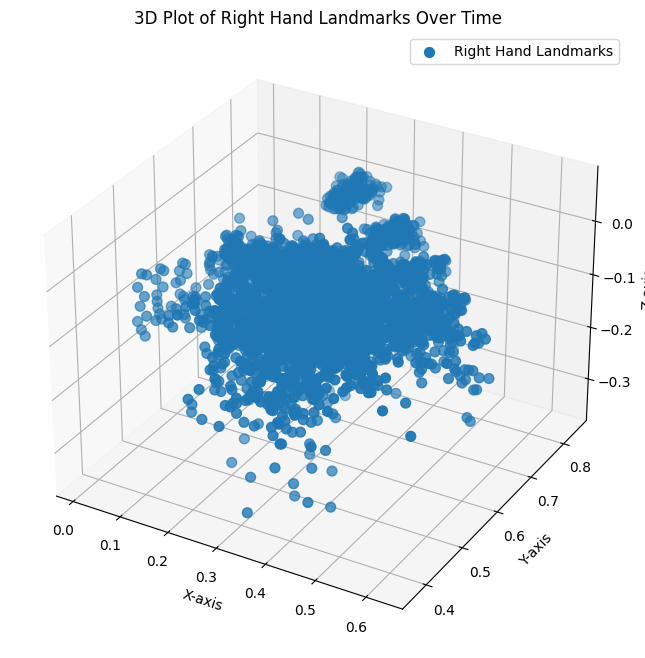

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming sample_sequence_df is a DataFrame with columns 'x_right_hand_1', 'y_right_hand_1', 'z_right_hand_1', ...

# Get the hand landmarks for the right hand
x_hand = sample_sequence_df.filter(regex="x_right_hand.*").values
y_hand = sample_sequence_df.filter(regex="y_right_hand.*").values
z_hand = sample_sequence_df.filter(regex="z_right_hand.*").values

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the hand landmarks
ax.scatter(x_hand, y_hand, z_hand, label='Right Hand Landmarks', marker='o', s=50)

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Add legend
ax.legend()

# Show the 3D plot
plt.title('3D Plot of Right Hand Landmarks Over Time')
plt.show()



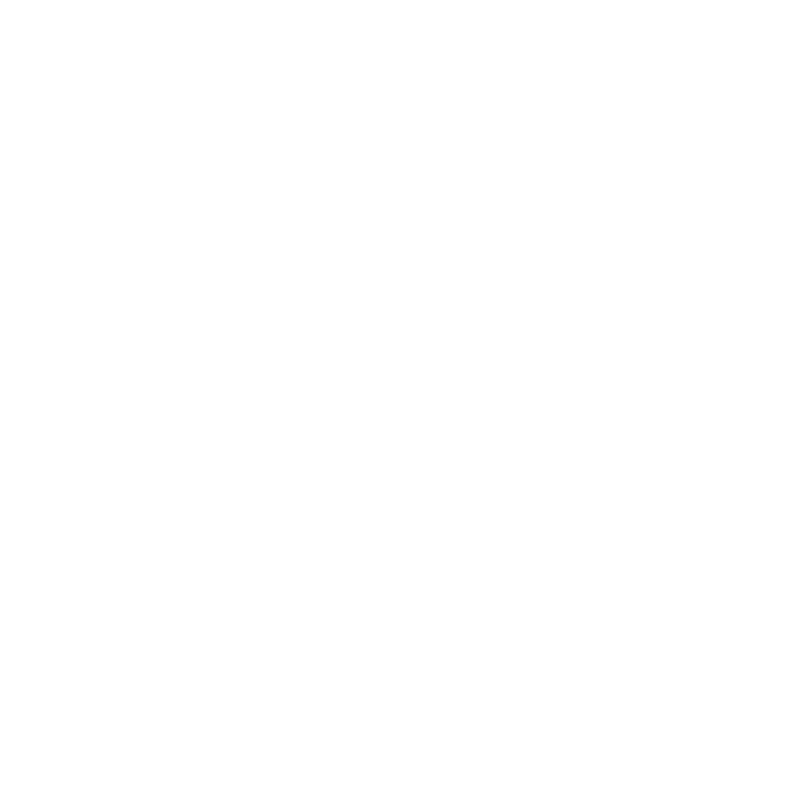

In [8]:
#Creating and animated image of right hand for phrase: 1383 william lanier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import mediapipe as mp
import numpy as np


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Function to initialize the 3D plot for animation
def init():
    ax.scatter([], [], [], label='Right Hand Landmarks', marker='o', s=50)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax,

# Function to update the 3D plot for each frame in animation
def update(frame):
    ax.cla()  # Clear the previous frame
    ax.scatter(x_hand[:frame], y_hand[:frame], z_hand[:frame], label='Right Hand Landmarks', marker='o', s=50)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax,

# Create the animation
animation = FuncAnimation(fig, update, frames=len(x_hand), init_func=init, blit=True)

# Show the 3D animation
plt.title('3D Animation of Right Hand Landmarks')
plt.show()


# Preprocess the data
Ok before preprossing the data let me clerify that our motive is to extract landmarkes data and treat it as an vector input to the transformer model thatswhy our preprocessing of the data will be accordingly. some steps are listed below  
1. Extract Relevant Features:
              Collect hand landmarks and pose coordinates for hands from each frame. 
2. Rearrange Data:
             Organize the data so that each Parquet file includes both landmark data and its corresponding phrase.
3. TFRecord Format:
             Convert the data to TFRecord format for efficient storage and retrieval.
4. Normalization/Scaling:
             Normalize or scale hand landmark coordinates to ensure consistent feature scales.
5. Handling Missing Data:
             Address missing values by filling them with zeros, means, or using advanced imputation.
6. Sequence Padding:
             If needed, pad sequences to a fixed length for consistent input dimensions.

**imageacdhba**

ASL fingerspelling focus on tha hand movement and hand pose we going to take all the righthand and lefthand points. And for the hand pose we are taking  13, 15, 17, 19, 21 14, 16, 18, 20, 22 this poins 

In [9]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

# Create x,y,z label names from coordinates

In [10]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

Create feature columns from the extracted coordinates.

In [11]:
FEATURE_COLUMNS = X + Y + Z
len(FEATURE_COLUMNS)

156

In FEATURE_COLUMNS there is 156 columns



Store ids of each coordinate labels to lists

In [12]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

# write the dataset as TFRecords
We have created a new column named FEATURE_COLUMNS from the existing paraquet files structure. We have handpicked the data for pose,left-hand,right-hand to be included in this new feature_column. The size of this new column is 156 which is spread across to capture the details i.e left/right-hand and pose.


In [13]:
# Set length of frames to 128
FRAME_LEN = 200

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(df.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = df.loc[df["file_id"] == file_id]
    # Fetch the parquet file
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

# Get the saved TFRecord files into a list


In [14]:
tf_records = df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")


List of 68 TFRecord files.


# Load character_to_prediction json file

In [15]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

# Resizing and Padding:-
 The hand landmark preprocessing function ensures uniformity in length by resizing to a fixed size and pads with zeros if needed. It identifies the dominant hand based on fewer NaN values, signifying its presence in the frame. The chosen hand's coordinates are normalized by subtracting the mean and dividing by the standard deviation. Handling NaN values involves replacing them with zeros. The final tensor, a combination of hand and pose information, is reshaped for ASL fingerspelling recognition. This process enhances data consistency and prepares it for effective use in deep learning models.

In [16]:
# Reference: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

# Create function to parse data from TFRecord format
This function will read the TFRecord data and convert it to Tensors.
It returns a tuple of tensors containing landmarks and phrases.

In [17]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

# Create function to convert the data

This function transposes and applies masks to the landmark coordinates. It also vectorizes the phrase corresponding to the landmarks using character_to_prediction_index.json

In [18]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

Use the functions we defined above to create the final dataset.

# Train and validation split/Create the final datasets

In [19]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

# Create a TFRecordDataset for training data, decode, convert, batch, prefetch, and cache
train_ds = tf.data.TFRecordDataset(tf_records[:train_len]) \
    .map(decode_fn) \
    .map(convert_fn) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE) \
    .cache()

# Create a TFRecordDataset for validation data, decode, convert, batch, prefetch, and cache
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]) \
    .map(decode_fn) \
    .map(convert_fn) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE) \
    .cache()


In [20]:
for i, element in enumerate(train_ds.take(1)):  
    features, labels = element
    print(f"Batch {i + 1} - Features shape: {features.shape}, Labels shape: {labels.shape}")
    print("First sequence in the batch:")
    print("Features:")
    print(features[0])
    print("Labels:")
    print(labels[0])
    print("\n")

Batch 1 - Features shape: (64, 200, 78), Labels shape: (64, 64)
First sequence in the batch:
Features:
tf.Tensor(
[[-0.27655613  1.5076838   2.3224409  ...  0.47083145  0.7710637
  -3.7243094 ]
 [ 0.          0.          0.         ...  0.39278966  0.84587616
  -3.1558092 ]
 [ 0.          0.          0.         ...  0.45422083  0.8396666
  -3.5316234 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(200, 78), dtype=float32)
Labels:
tf.Tensor(
[60 18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59], shape=(64,), dtype=int32)




# Input Layers for Transformer Model

Refernce - [Link](https://keras.io/examples/audio/transformer_asr/#define-the-transformer-input-layer)

In [21]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

# Transformer Encoder Layer

Refernce - [Link](https://keras.io/examples/audio/transformer_asr/#transformer-encoder-layer)

In [22]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Decoder Layer of Transformer Model

In [23]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)
    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

# Creation of Transformer Model

Reference - [Link](https://keras.io/examples/audio/transformer_asr/#complete-the-transformer-model)

In [24]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(self, num_hid=64, num_head=2, num_feed_forward=128, source_maxlen=100, target_maxlen=100, num_layers_enc=4, num_layers_dec=1, num_classes=60):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid)

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [TransformerEncoder(num_hid, num_head, num_feed_forward) for _ in range(num_layers_enc)]
        )

        for i in range(num_layers_dec):
            setattr(self, f"dec_layer_{i}", TransformerDecoder(num_hid, num_head, num_feed_forward))

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric, self.acc_metric]

    def train_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input], training=True)
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.loss_metric.update_state(loss)
        self.acc_metric.update_state(dec_target, preds, sample_weight=mask)

        return {"loss": self.loss_metric.result(), "accuracy": self.acc_metric.result()}

    def test_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input], training=False)
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)

        self.loss_metric.update_state(loss)
        self.acc_metric.update_state(dec_target, preds, sample_weight=mask)

        return {"loss": self.loss_metric.result(), "accuracy": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training=False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training=False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


Callback function to display prediction-ground truth and accuracy


In [25]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            
            accuracy = logs.get('accuracy')  # Access accuracy from the training logs
            
            print(f"Epoch {epoch + 1}, Accuracy: {accuracy}")
            print(f"Target:     {target_text.replace('-', '')}")
            print(f"Prediction: {prediction}\n")


# Training of Transformer Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

batch = next(iter(valid_ds))
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>'])

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen=FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Include EarlyStopping callback in the training process
history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb,early_stopping], epochs=40)


Epoch 1/40
    632/Unknown - 72s 83ms/step - loss: 0.8917 - accuracy: 0.2310Epoch 1, Accuracy: 0.2310270220041275
Target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <177 sterth corererive>

Epoch 1, Accuracy: 0.2310270220041275
Target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <+31-111-1999>

Epoch 1, Accuracy: 0.2310270220041275
Target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <599-263-6300>

Epoch 1, Accuracy: 0.2310270220041275
Target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <delene corin>

Epoch 1, Accuracy: 0.2310270220041275
Target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <https://ww.comangenthange>

Epoch 1, Accuracy: 0.2310270220041275
Target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <8866 rar rin roan>

Epoch 1, Accuracy: 0.2310270220041275
Targe

We have Implemented early stopping during training to stop training when the validation performance stops improving. This helps prevent overfitting and saves training time.

In [27]:
val_loss, val_accuracy = model.evaluate(valid_ds)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

164/164 [==============================] - 2s 14ms/step - loss: 0.5066 - accuracy: 0.6896
Validation Loss: 0.5066
Validation Accuracy: 68.96%


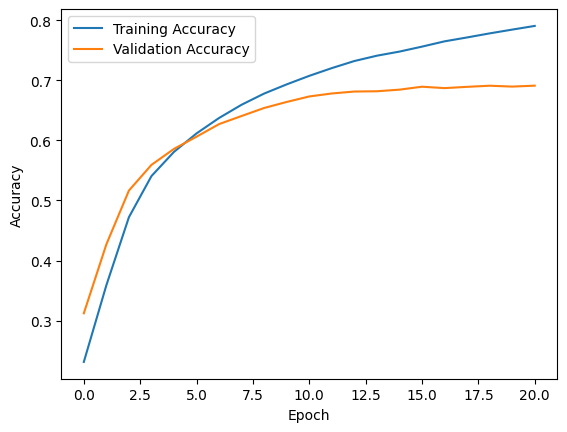

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('training_validation_accuracy_plot.png')
plt.legend()
plt.show()

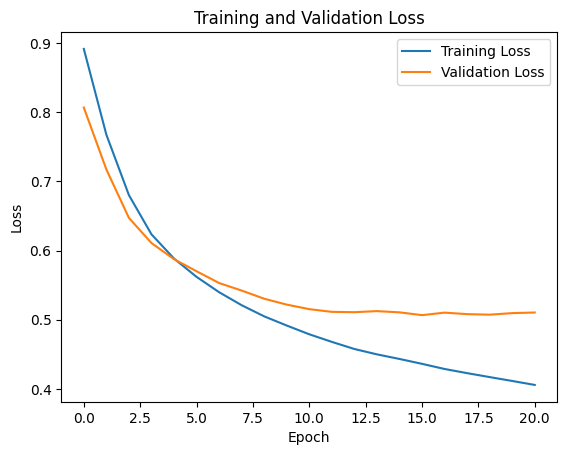

In [29]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_plot.png')
plt.show()

From the provided plots, it's evident that the model's performance, as measured by validation accuracy and validation loss, remains relatively stable over the training epochs. This indicates a potential issue with the model's ability to generalize beyond the training data, suggesting the need for further exploration into hyperparameter tuning, regularization techniques, or potential data-related challenges to improve overall model performance on unseen data.

# Hyperparameter tuning

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from kerastuner.engine import tuner_utils

# Assume FRAME_LEN is defined
FRAME_LEN = ...

# Define the model-building function
def build_model(hp):
    model = Transformer(
        num_hid=hp.Int('num_hid', min_value=100, max_value=400, step=50),
        num_head=hp.Int('num_head', min_value=2, max_value=8, step=1),
        num_feed_forward=hp.Int('num_feed_forward', min_value=200, max_value=800, step=100),
        source_maxlen=FRAME_LEN,
        target_maxlen=64,
        num_layers_enc=hp.Int('num_layers_enc', min_value=1, max_value=3, step=1),
        num_layers_dec=hp.Int('num_layers_dec', min_value=1, max_value=3, step=1),
        num_classes=62
    )

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6]))

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model

# Instantiate the RandomSearch tuner with 'val_accuracy' as the objective
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_tuning_directory',
    project_name='my_transformer_tuning',
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Perform the hyperparameter search with the callback
tuner.search(train_ds, validation_data=valid_ds, epochs=30, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Compile the final model
final_model.compile(optimizer=final_model.optimizer, loss=loss_fn, metrics=['accuracy'])

# Include EarlyStopping callback in the training process
history = final_model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb, early_stopping], epochs=100)

# Save the final model in HDF5 format
final_model.save("final_model", save_format="tf")



Best Hyperparameters: {'num_hid': 100, 'num_head': 7, 'num_feed_forward': 700, 'num_layers_enc': 3, 'num_layers_dec': 3, 'learning_rate': 0.0001}
Epoch 1/100
    631/Unknown - 61s 54ms/step - loss: 0.8809 - accuracy: 0.2360Epoch 1, Accuracy: 0.2360135018825531
Target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <311 stert st roure road>

Epoch 1, Accuracy: 0.2360135018825531
Target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <611-191-1999>

Epoch 1, Accuracy: 0.2360135018825531
Target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <996-963-9692>

Epoch 1, Accuracy: 0.2360135018825531
Target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <derine corerin>

Epoch 1, Accuracy: 0.2360135018825531
Target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Prediction: <https://wwananan.comast>

Epoch 1, Accuracy: 0.2360135018825531
Targ

In [41]:
final_model = tf.keras.models.load_model("final_model")
final_model

In [32]:
best_hps.values

{'num_hid': 100,
 'num_head': 7,
 'num_feed_forward': 700,
 'num_layers_enc': 3,
 'num_layers_dec': 3,
 'learning_rate': 0.0001}

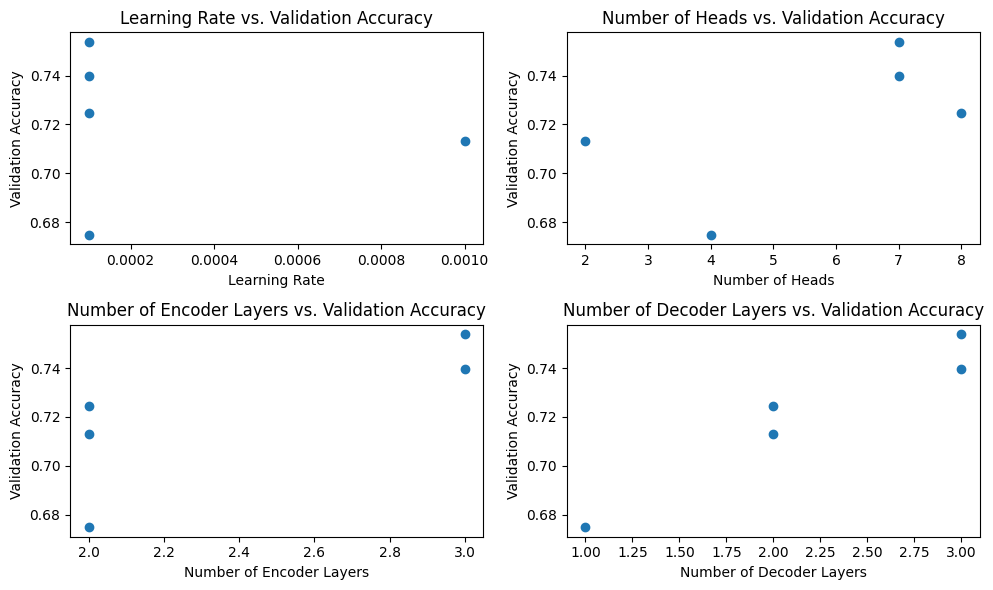

In [33]:
import matplotlib.pyplot as plt

# Get the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=5)

# Extract relevant information
val_acc = [trial.metrics.get_last_value('val_accuracy') for trial in best_trials]
learning_rates = [trial.hyperparameters.get('learning_rate') for trial in best_trials]
num_heads = [trial.hyperparameters.get('num_head') for trial in best_trials]
num_layers_enc = [trial.hyperparameters.get('num_layers_enc') for trial in best_trials]
num_layers_dec = [trial.hyperparameters.get('num_layers_dec') for trial in best_trials]

# Plot hyperparameter vs. validation accuracy
plt.figure(figsize=(10, 6))

# Plot and save Learning Rate vs. Validation Accuracy
plt.subplot(2, 2, 1)
plt.scatter(learning_rates, val_acc)
plt.title('Learning Rate vs. Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.savefig('learning_rate_vs_validation_accuracy.png')

# Plot and save Number of Heads vs. Validation Accuracy
plt.subplot(2, 2, 2)
plt.scatter(num_heads, val_acc)
plt.title('Number of Heads vs. Validation Accuracy')
plt.xlabel('Number of Heads')
plt.ylabel('Validation Accuracy')
plt.savefig('number_of_heads_vs_validation_accuracy.png')

# Plot and save Number of Encoder Layers vs. Validation Accuracy
plt.subplot(2, 2, 3)
plt.scatter(num_layers_enc, val_acc)
plt.title('Number of Encoder Layers vs. Validation Accuracy')
plt.xlabel('Number of Encoder Layers')
plt.ylabel('Validation Accuracy')
plt.savefig('number_of_encoder_layers_vs_validation_accuracy.png')

# Plot and save Number of Decoder Layers vs. Validation Accuracy
plt.subplot(2, 2, 4)
plt.scatter(num_layers_dec, val_acc)
plt.title('Number of Decoder Layers vs. Validation Accuracy')
plt.xlabel('Number of Decoder Layers')
plt.ylabel('Validation Accuracy')
plt.savefig('number_of_decoder_layers_vs_validation_accuracy.png')

plt.tight_layout()
plt.show()


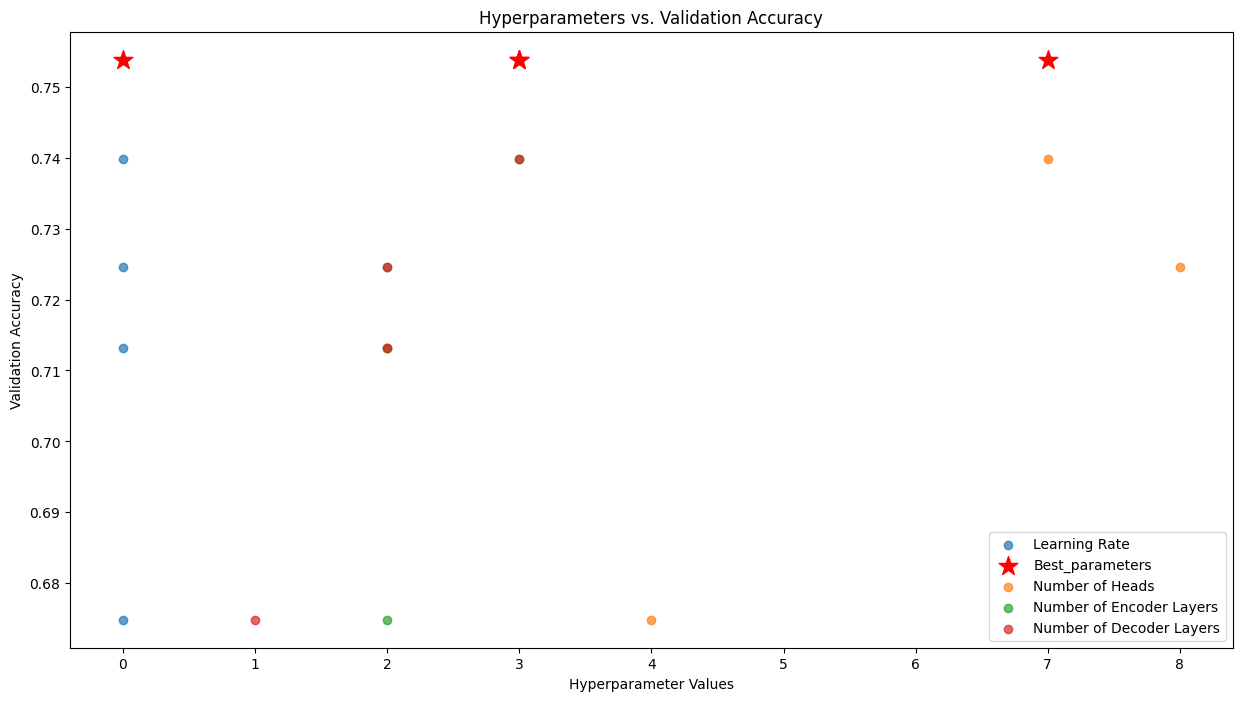

In [34]:
import matplotlib.pyplot as plt

# Retrieve the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=5)

# Extract relevant information
val_acc = [trial.metrics.get_last_value('val_accuracy') for trial in best_trials]
learning_rates = [trial.hyperparameters.get('learning_rate') for trial in best_trials]
num_heads = [trial.hyperparameters.get('num_head') for trial in best_trials]
num_layers_enc = [trial.hyperparameters.get('num_layers_enc') for trial in best_trials]
num_layers_dec = [trial.hyperparameters.get('num_layers_dec') for trial in best_trials]

# Find the index of the best trial
best_trial_index = val_acc.index(max(val_acc))

# Plot hyperparameters vs. validation accuracy in a single plot
plt.figure(figsize=(15, 8))

# Scatter plot for Learning Rate
plt.scatter(learning_rates, val_acc, label='Learning Rate', alpha=0.7)
# Highlight the best point
plt.scatter(learning_rates[best_trial_index], val_acc[best_trial_index], color='red', marker='*', s=200, label='Best_parameters')

# Scatter plot for Number of Heads
plt.scatter(num_heads, val_acc, label='Number of Heads', alpha=0.7)
# Highlight the best point
plt.scatter(num_heads[best_trial_index], val_acc[best_trial_index], color='red', marker='*', s=200)

# Scatter plot for Number of Encoder Layers
plt.scatter(num_layers_enc, val_acc, label='Number of Encoder Layers', alpha=0.7)
# Highlight the best point
plt.scatter(num_layers_enc[best_trial_index], val_acc[best_trial_index], color='red', marker='*', s=200)

# Scatter plot for Number of Decoder Layers
plt.scatter(num_layers_dec, val_acc, label='Number of Decoder Layers', alpha=0.7)
# Highlight the best point
plt.scatter(num_layers_dec[best_trial_index], val_acc[best_trial_index], color='red', marker='*', s=200)

# Add labels and title
plt.title('Hyperparameters vs. Validation Accuracy')
plt.xlabel('Hyperparameter Values')
plt.ylabel('Validation Accuracy')
plt.legend()

# Save the figure
plt.savefig('hyperparameter_vs_validation_accuracy.png')
plt.show()



# Create TFLite model


In [35]:
import tensorflow as tf

# Load the saved model
final_model = tf.keras.models.load_model("final_model")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("final_model.tflite", "wb") as f:
    f.write(tflite_model)


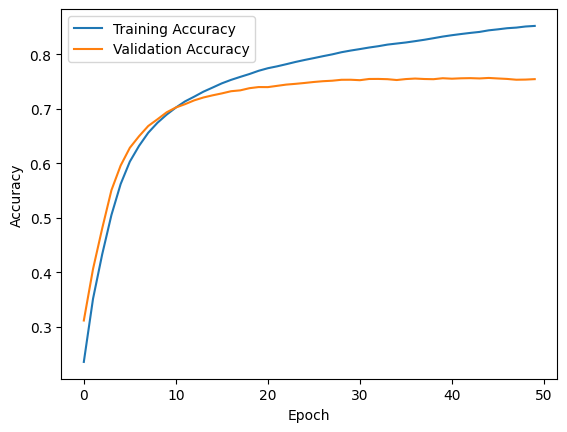

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('final_training_validation_accuracy_plot.png')
plt.legend()
plt.show()

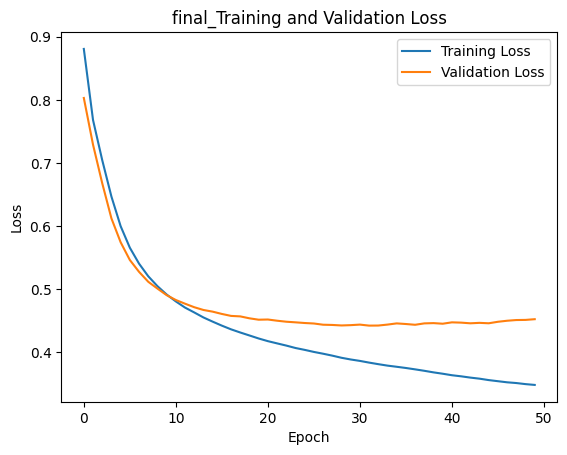

In [44]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('final_Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_training_validation_loss_plot.png')
plt.show()